In [27]:
# [데이터 호출]

import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/wikibook/machine-learning/2.0/data/csv/basketball_stat.csv')

df.drop(['2P', 'AST', 'STL'], axis=1, inplace = True)

#테스트데이터 분할
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.2)

In [28]:
# [최적의 SVM 파라미터 찾기]

##RBF커널 -> 두가지의 파라미터 존재 : 1. 비용(C) - 마진의 너비를 조정 2. 결정 경계선의 곡률을 조정

In [29]:
#사이킷런의 그리드서치 : 최적의 비용과 감마 도출

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC 
import numpy as np

def svc_param_selection(X_train, y_train, nfolds):
  svm_parameters = [
                    {'kernel': ['rbf'],
                     'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
                     'C' : [0.01, 0.1, 1, 10, 100, 1000]
                     }]

  clf = GridSearchCV(SVC(), svm_parameters, cv=nfolds)
  clf.fit(X_train, y_train)
  print(clf.best_params_)

  return clf


X_train = train[['3P', 'BLK']]
y_train = train[['Pos']]


clf = svc_param_selection(X_train, y_train.values.ravel(), 10)

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}


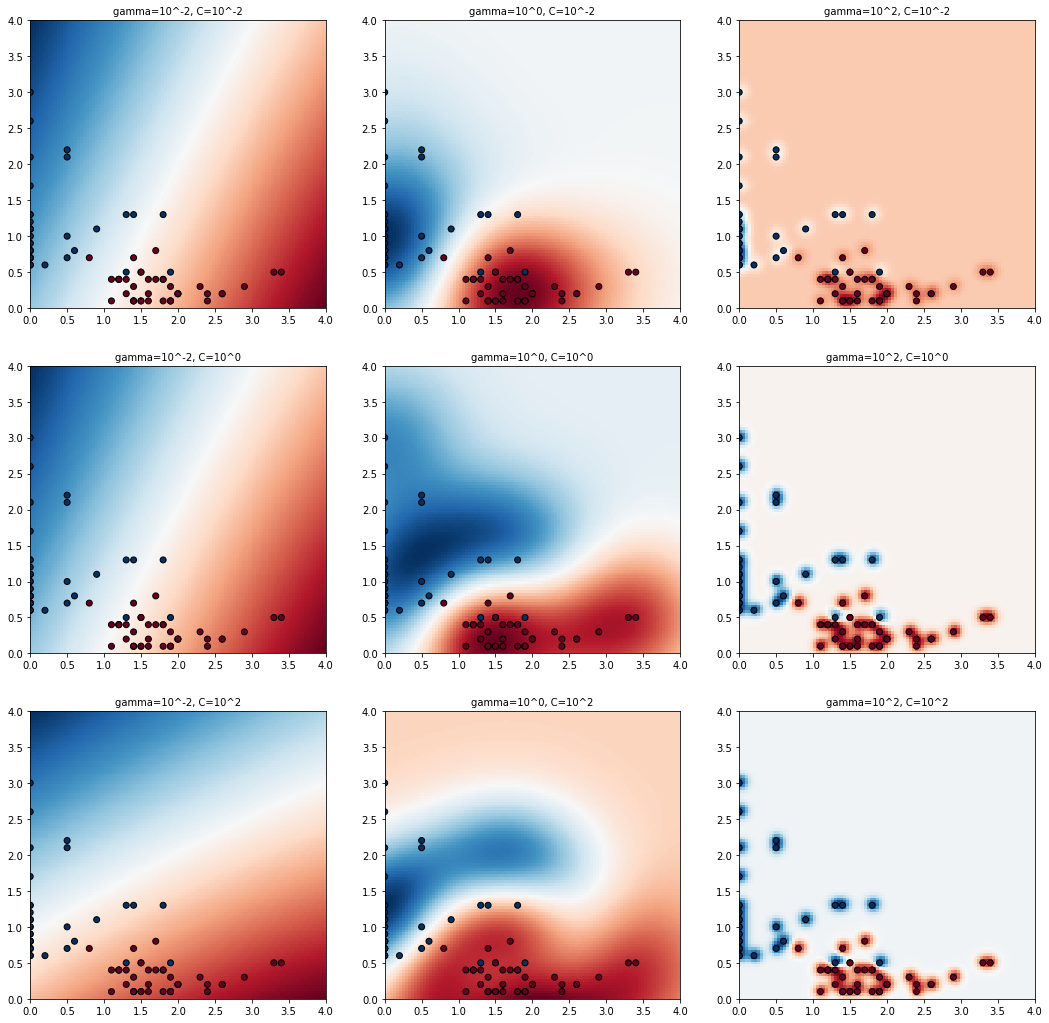

In [30]:
#[결정 경계선 시각화]


## 시각화할 비용 후보들을 저장
C_candidates = []
C_candidates.append(clf.best_params_['C'] * 0.01)
C_candidates.append(clf.best_params_['C'])
C_candidates.append(clf.best_params_['C'] * 100)

## 시각화할 감마 후보들을 저장
gamma_candidates = []
gamma_candidates.append(clf.best_params_['gamma'] * 0.01)
gamma_candidates.append(clf.best_params_['gamma'])
gamma_candidates.append(clf.best_params_['gamma'] * 100)

## 3점슛과 블로킹 횟수로 학습
X = train[['3P', 'BLK']]

## 농구선수 표지션을 학습 모델의 분류값으로 사용
Y = train['Pos'].tolist()

## 시각화를 위해 센터와 슈팅가드를 숫자로 표현
position = []
for gt in Y:
  if gt == 'C':
    position.append(0)
  else:
    position.append(1)

##파라미터 후보들을 조합하여 학습된 모델들을 저장
classifiers = []

for C in C_candidates:
  for gamma in gamma_candidates:
      clf = SVC(C=C, gamma=gamma)
      clf.fit(X, Y)
      classifiers.append((C, gamma, clf))

##각 모델들을 시각화
import matplotlib.pyplot as plt
plt.figure(figsize = (18,18))
xx, yy = np.meshgrid(np.linspace(0, 4, 100), np.linspace(0, 4, 100))

for (k, (C, gamma, clf)) in enumerate(classifiers):
  Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  plt.subplot(len(C_candidates), len(gamma_candidates), k+1)
  plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)),
            size = 'medium')
  
  plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
  plt.scatter(X['3P'], X['BLK'], c=position, cmap=plt.cm.RdBu_r,
              edgecolors='k')


In [32]:
#[모델테스트]
##gridsearch를 통해 얻은 C와 감마를 통해 학습된 모델 테스트

X_test = test[['3P', 'BLK']]
y_test = test[['Pos']]

#최적의 파라미터로 학습된 모델로 테스트를 진행
y_true, y_pred = y_test, clf.predict(X_test)

print(classification_report(y_true, y_pred))
print()
print("accuracy : " + str(accuracy_score(y_true, y_pred)))

              precision    recall  f1-score   support

           C       1.00      0.56      0.71         9
          SG       0.73      1.00      0.85        11

    accuracy                           0.80        20
   macro avg       0.87      0.78      0.78        20
weighted avg       0.85      0.80      0.79        20


accuracy : 0.8


In [33]:
#모델값과 실제값 비교

comparison = pd.DataFrame({'prediction' : y_pred,
                           'ground_truth' : y_true.values.ravel()})
comparison

,prediction,ground_truth
0,SG,SG
1,C,C
2,SG,C
3,SG,C
4,C,C
5,SG,SG
6,C,C
7,SG,SG
8,SG,C
9,C,C
